# Power-law networks

Complex networks sit at the junction between order and chaos. A grid is a simple, regular, un-complex network; a random ER network has properties that are counter-intuitive that require a change of perspective to understand. For many years, ER networks were used extensively to model a range of phenomena, both statically and through processes such as [epidemic spreading](epidemic-spreading.ipynb) that we'll come to later.

However, it was clear that not all real-world networks follow the ER scheme. In an ER network we have a clear expectation of the mean degree: the most likely number of edges incident on an "average" node chosen at random. This clearly doesn't happen in many networks, though. If we think of the World Wide Web &ndash; where the nodes are web sites and the edges are incoming hyperlinks from other sites &ndash; then clearly some nodes (for example [BBC News](http://news.bbc.com)) have massively more incident edges than others (for example [simondobson.org](http://www.simondobson.org)). Indeed, it seems likely that the vast majority of nodes in this network &ndash; sites on the web &ndash; have degrees in low single figures, while a relatively small number of other nodes have degrees in the hundreds of thousands. This isn't an ER structure at all: if the web was an ER network then most of the nodes would have the same degree (the average) with nodes with small or high degrees being equally unlikely. If you treat the web as an ER network, all the answers suggested by your analysis will be wrong when compared to reality. It simply doesn't work as a mathematical model.

It was observations like these that led to to the exploration of different degree distributions, and for processes that could give rise to them. This led to the discovery of power-law networks, and it was power-law networks that in many ways put complex networks on the wider scientific map. What had previously been a niche area mainly of interest to pure mathematicians was suddenly shown to have broad application to a much wider range of phenomena than anyone had previously suspected.  

In [1]:
import math
import numpy as np
import numpy.random as rnd

import networkx as nx

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.cm as cmx
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

When we discussed [ER networks](er-networks.ipynb) we first treated them in simulation and then looked at the mathematics. This time we'll do the opposite: consider the analysis of power-law networks, and then show how they can be created for simulations. 

## The mathematics of the power law distribution

A power law degree distribution takes the form $P(deg(v)= k) = C \, k^{-\alpha}$ where $\alpha$ is the *coefficient* (or the *exponent*) of the distribution. The coefficient isn't a completely free choice, and has important effects on the way the network induced by the degree distribution operates: typically we have $2 \leq \alpha \leq 3$ (we'll see why later).

for this exponential function, we have a variable $k$ raised to a constant power: constant for a particular distribution, anyway. Moreover, $k$ is raised to a *negative* power, meaning that the probability is *decreasing* exponentially as $k$ increases. This suggests that high-degree nodes will be extremely unlikely to appear.

### Normalising the distribution

For the equation $p_k = C \, k^{-\alpha}$ to be a valid probability distribution, it has to be normalised, so:

$$
\begin{align}
    1 &= \sum_{k = 1}^{\infty} p_k \\
      &= \sum_{k = 1}^{\infty} C \, k^{-\alpha} \\
      &= C \sum_{k = 1}^{\infty} k^{-\alpha}
\end{align}
$$

Therefore we can find $C$ as: 

$$
\begin{align}
    C &= \frac{1}{\sum_{k = 1}^{\infty} k^{-\alpha}}
\end{align}
$$

The denominator of this fraction sums each possible node degree to the inverse power of the coefficient of the distribution. If $\alpha \leq 0$ this sum is clearly infinite, but for positive values of $\alpha$ it is finite. Computing it may seem like a challenge, although it could clearly be approximated numerically by picking a large-enough value of $k$ to sum up to: however, it turns out that a related function is relatively well-known in mathematics as the [Hurwitz zeta function](https://en.wikipedia.org/wiki/Hurwitz_zeta_function) (a variant on the better-known [Riemann zeta function](https://en.wikipedia.org/wiki/Riemann_zeta_function)), defined by:

$$
\zeta(x, q) = \sum_{k = 0}^{\infty} (k + q)^{-x}
$$

We therefore immediately get that:

$$
C = \frac{1}{\zeta(\alpha, 1)}
$$

(so that the sum in the zeta function runs from $k = 1$, not $k = 0$), and so:

$$
p_k = \frac{k^{-\alpha}}{\zeta(\alpha, 1)}
$$

will be a properly-normalised power-law degree distribution for $k > 0$ and $p_0 = 0$.

In the literature you will often see the power law written proportionally, $p_k \propto k^{-\alpha}$. This hides the constant of proportionality that is given by the zeta function, making the maths slightly easier to read but harder to implement, since one needs the constant to normalise the distribution to sum to 1. It's important to remember that the zeta function looks scary but is actually a straightforward concept (a sum of powers) that's easy to use.

### What does a power law distribution look like?

The shapes of functions like these aren't immediately obvious the first time you see them, but we can esily plot the degree distribution for a network with a power-law degree distribution. First we need a distribution function:

In [2]:
from scipy.special import zeta

def powerlaw( alpha ):
    """Generate a power-law distribution with exponent -alpha"""
    C = 1.0 / zeta(alpha, 1)
    def model( k ):
        return C * pow((k + 0.0), -alpha)
    return model

Note that `zeta(alpha, 1)` is the Python call for $\zeta(\alpha, 1)$ defined in the `scipy.special` special functions library. (Knowing that the distribution uses the zeta function actually simplifies matters: without it, we would have to approximate the sum of powers manually.) Then we can plot the distribution:

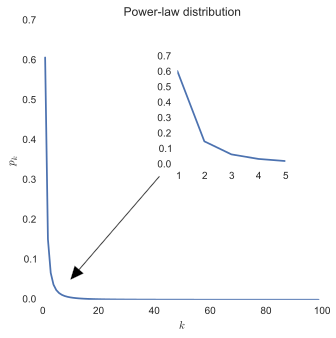

In [6]:
fig = plt.figure(figsize = (5,5))
ax = fig.gca()

# main curve
plt.xlabel("$k$")
plt.ylabel("$p_k$")
plt.plot(xrange(1, 100), map(powerlaw(2), xrange(1, 100)))
plt.title('Power-law distribution')

# inset for the area of main interest
ax.annotate('', xy = (10, 0.05), xytext = (42, 0.31),
            arrowprops = dict(width = 1, facecolor = 'black'))
axs = plt.axes([0.5, 0.5, 0.3, 0.3], axisbg = 'w')
plt.plot(xrange(1, 6), map(powerlaw(2), xrange(1, 6)))
plt.setp(axs, xticks = xrange(1, 6))

plt.show()

We can immediately take from this plot that the probability of having a large-degree node drops off *very* quickly: exponentially quickly, in fact. The inset diagram shows the dynamic part of the curve up to $k = 5$. The probability of a node having a single incident edge is about 0.6, while the probability of two edges is around 0.15, and so on: beyond five or six edges the probability becomes basically zero.

What effect does the coefficient of the distribution have? We can plot several values of $\alpha$ on the same axes to see:

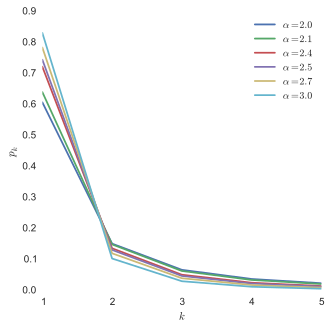

In [8]:
fig = plt.figure(figsize = (5,5))

# plot a range of possible alpha values
plt.xlabel("$k$")
plt.ylabel("$p_k$")
for alpha in [2.0, 2.1, 2.4, 2.5, 2.7, 3.0]:
    plt.plot(xrange(1, 6), map(powerlaw(alpha), xrange(1, 6)), label = "$\\alpha = " + str(alpha) + "$")
plt.setp(fig.gca(), xticks = xrange(1, 6))
plt.legend()

plt.show()

As the coefficient increases, the probability of one-edge nodes increases and the probabilities of higher-degree nodes decreases. 

### The power law network, the ER network, and high-degree nodes

However, there's an important thing to note about the graph above. As $k$ increases, the probability $p_k$ of enciuntering a node with that degree approaches zero. But it doesn't *become* zero: there's a finite, though small, probability that we'll encounter a high-degree node. It's this property that makes power-law networks so different from other kinds of network, and particularly from the ER networks we saw [earlier](er-networks.ipynb).

To see this, let's plot the degree distributions of the power-law and ER networks on the same axes. We'll use a log-log scale for this, as it makes the comparison dramatic and is the way it often appears in the literature. We'll use the same approach as we used earlier, using a Poisson distribution for the ER network and our power-law function from above. 

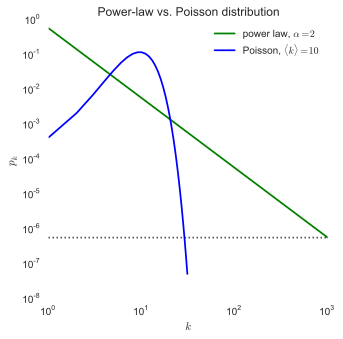

In [38]:
def poisson( n, pEdge ):
    """Return a model function for the Poisson distribution with n nodes and
    edge probability pEdge."""
    def model( k ):
        return (pow(n * pEdge, k) * math.exp(-n * pEdge)) / math.factorial(k)
    return model

fig = plt.figure(figsize = (5,5))

# plot the distributions
plt.xlabel("$k$")
plt.ylabel("$p_k$")
plt.loglog()
plt.plot(xrange(1, 1000), map(powerlaw(2), xrange(1, 1000)), 'g-', label="power law, $\\alpha = 2$")
plt.plot(xrange(1, 32), map(poisson(1000, 0.01), xrange(1, 32)), 'b-', label="Poisson, $\\langle k \\rangle = 10$")
plt.title('Power-law vs. Poisson distribution')
plt.legend(loc = 'upper right')

# add important points mentioned in the text
plt.plot([1, 1000], map(powerlaw(2), [1000, 1000]), 'k:')

plt.show()

What is this graph telling us? Let's consider the power-law line first. This drops-off as a straight line, but it's being plotted on a log-log scale, meaning that the probability of encountering a high-degree node falls exponentially. However, the chance of encountering a node of $k = 1000$ is still finite, at about $10^{-6}$ (the gtted line in the figure).

Compare this to the Poisson line. The value of $p_k$ peaks at $k = 10$, the mean degree. It then drops-off precipitously as $k$ increases. Just looking at the steepness of the curve, the probability of encountering a node of $k = 1000$ is clearly so small as to be essentially impossible: it is actually too small for Python to properly compute. (For the mathematically inclined, this happens because the equation for the Poisson distribution includes a fraction whose denominator is a factorial that grows super-exponentially, causing the super-exponential decrese in $p_k$.)

### Statistical properties

As we did for [ER networks](http://localhost:8080/er-networks.ipynb), we can ask about the various summary statistics that relate to the power-law degree distribution. Of greatest interests are the statistical moments, especially the mean and variance. Just considering mean degree to start with, we would therefore have:

$$
\begin{align}
    \langle k \rangle = \mathbb{E}(k) &= \sum_{k = 1}^{\infty} k \, \frac{k^{-\alpha}}{\zeta(\alpha, 1)} \\
                                      &= C \sum_{k = 1}^{\infty} k \, k^{-\alpha} \\
                                      &= C \sum_{k = 1}^{\infty} k^{1 - \alpha}
\end{align}
$$

where $C = 1 / \zeta(\alpha, 1)$. We can approximate the sum using an integral since it drops-off so quickly, so:

$$
\begin{align}
    \langle k \rangle &= C \int_{k = 1}^{\infty} k^{1 - \alpha} \\
                      &= \frac{C}{2 - \alpha} \left [ k^{2 - \alpha} \right ]_{k = 1}^{k = \infty}
\end{align}
$$

Look at the bracketed term. If $2 - \alpha < 0$ then $k^{2 - \alpha}$ gets progressively smaller as $k$ gets larger, and the term is well-defined as $k \rightarrow \infty$. However, if $2 - \alpha \ge 0$, then $k^{2 - \alpha}$ gets larger along with $k$, and the term diverges: the distribution will have infinite mean degree. The same argument works for higher moments, where we encounter:

$$
\begin{align}
    \langle k^m \rangle &= \sum_{k = 1}^{\infty} k^m \, \frac{k^{-\alpha}}{\zeta(\alpha, 1)} \\
                        &= C \sum_{k = 1}^{\infty} k^m \, k^{-\alpha} \\
                        &= C \sum_{k = 1}^{\infty} k^{m - \alpha} \\
                        &= C \int_{k = 1}^{\infty} k^{m - \alpha} \\
                        &= \frac{C}{m - \alpha + 1} \left [ k^{m - \alpha + 1} \right ]_{k = 1}^{k = \infty}
\end{align}
$$

So the $m$'th moment of a distribution is stable for $m + 1 - \alpha < 0$ &ndash; that is, for $\alpha > m + 1$ &ndash; and diverges otherwise.

An immediate consequence is that $\alpha = 2$ leads to a distribution with infinite mean degree, but finite for larger values. A less immediate consequence is the effect on $\langle k^2\rangle$, the second moment of variance of the distribution. The second moment is finite only if $\alpha > 3$. As noted above, we typically see $2 < \alpha \leq 3$, suggesting that the second moment will be infinite. However, just as we can calculate the mean of a network directly by counting the degrees of the nodes, we can similarly compute the variance directly:

$$
\langle k^2 \rangle = \frac{1}{N} \sum_{i = 1}^{N} \, deg(v_i)^2
$$

This sum will of course be finite for a finite network &ndash; which all real networks are. The power-law model therefore isn't ideal, as its predictions really only work in the limit as $N \rightarrow \infty$. In fact, for a real-world network with $N$ nodes, no self-loops or multi-edges, we will have a maximum possible node degree $k_{max} = N - 1$ where a node is connected to every other node in the network. This cuts-off the distribution so that

$$
\begin{align}
    \langle k^2 \rangle &\approx [ k^{m - \alpha + 1} ]_{k = 1}^{N} \\
                        &\approx N^{m - \alpha + 1}
\end{align}
$$

which again is finite if $N$ is.

## Power law with cutoff

The power law distribution allows for nodes with arbitrarily large degrees, albeit with smaller probabilities. In principle this means that the "tail" is infinitely long, and one can always have the chance of getting a node with a larger degree. In real networks, of course, this doesn't happen: there will be a point beyond which it's "practically impossible" to get a higher-degree node.

We can capture this by forcing the probability of a high-degree node to drop-off rapidly after a "cutoff" point. We label this cutoff $\kappa$ (kappa) to indicate the largest "likely" value of $k$. What we want is a power-law distribution whose tail drops-off rapidly after the cutoff at $\kappa$.

We could do this by defining a distrbution in which $p_k = 0$ for all $k > \kappa$. This works for some purposes, but not for others: the basic problem is that such a function isn't continuous &ndash; there's a rapid drop to zero at $p_{\kappa + 1}$ &ndash; and so techniques that rely differentiation and integraton can't be used; nor can we assume that the distribution is properly normalised, as the are under the curve won't be equal to one as required.

The solution is to build a *continuous* function that has the required drop-off in its tail. If we look for *exponential* drop-off, we simply need an exponential factor that goes to zero rapidly for all $k > \kappa$. We can accomplish this using a factor of $e^{-k/\kappa}$. This yields a *powerlaw distribution with cutoff* given by:

$$
    p_k = C k^{-\alpha} e^{-k/\kappa}
$$